In [1]:
import copy
from linearmodels.iv import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import scipy.stats
#import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from IPython.display import display, HTML

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('lines', linewidth=3)     # linewidth

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

u_train = np.asarray(df2['u']).reshape(-1, 1)
u_valid = np.asarray(df1['u']).reshape(-1, 1)
y_train = np.asarray(df2['y']).reshape(-1,1)
y_valid = np.asarray(df1['y']).reshape(-1,1)

/tmp/ipykernel_2126/1240242742.py:40: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_2126/1240242742.py:41: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_2126/1240242742.py:42: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_2126/1240242742.py:43: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


/tmp/ipykernel_2126/1850855107.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1['y_lag'+str(i)] = df_1['y'].shift(i)
/tmp/ipykernel_2126/1850855107.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1['u_lag'+str(i)] = df_1['u'].shift(i)
/tmp/ipykernel_2126/1850855107.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

,time,y,u,y_lag1,y_lag2,y_lag3,y_lag4,y_lag5,y_lag6,y_lag7,...,u_lag91,u_lag92,u_lag93,u_lag94,u_lag95,u_lag96,u_lag97,u_lag98,u_lag99,u_lag100
401,8.02,0.689008,-1.006586,0.872950,1.063234,1.126662,1.126662,1.139348,1.133005,1.113976,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
402,8.04,0.447980,-1.006586,0.689008,0.872950,1.063234,1.126662,1.126662,1.139348,1.133005,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
403,8.06,0.181582,-1.006586,0.447980,0.689008,0.872950,1.063234,1.126662,1.126662,1.139348,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
404,8.08,-0.053102,-1.006586,0.181582,0.447980,0.689008,0.872950,1.063234,1.126662,1.126662,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
405,8.10,-0.306815,-1.006586,-0.053102,0.181582,0.447980,0.689008,0.872950,1.063234,1.126662,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,18.50,0.828550,-1.006586,0.974435,1.037863,1.056891,1.037863,0.993463,0.936378,0.872950,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
926,18.52,0.638266,-1.006586,0.828550,0.974435,1.037863,1.056891,1.037863,0.993463,0.936378,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
927,18.54,0.397238,-1.006586,0.638266,0.828550,0.974435,1.037863,1.056891,1.037863,0.993463,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457
928,18.56,0.143525,-1.006586,0.397238,0.638266,0.828550,0.974435,1.037863,1.056891,1.037863,...,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457,0.993457


401    0.689008
402    0.447980
403    0.181582
404   -0.053102
405   -0.306815
         ...   
496    0.225982
497    0.162554
498    0.035697
499   -0.078473
500   -0.230701
Name: y, Length: 100, dtype: float64
##########
       u_lag1    u_lag2    u_lag3    u_lag4    u_lag5    u_lag6    u_lag7  \
401 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586  0.993457  0.993457   
402 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586  0.993457   
403 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586   
404 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586   
405 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586   
..        ...       ...       ...       ...       ...       ...       ...   
925 -1.006586 -1.006586 -1.006586 -1.006586  0.993457  0.993457  0.993457   
926 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586  0.993457  0.993457   
927 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586  0.993457   
928 -1

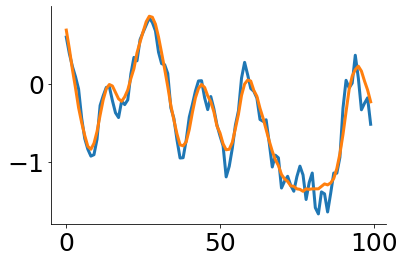

In [16]:
# make a copy of the training data
df_1 = copy.deepcopy(df2)

# define lags
ylag = 100
ulag = 100
lag = max(ulag,ylag)

# create a list of labels
lagged_u = ['u_lag'+str(i) for i in range(1, ulag+1)]
lagged_y = ['y_lag'+str(i) for i in range(1, ylag+1)]

# adding lags to the dataset
for i in range(1, ylag+1):
    df_1['y_lag'+str(i)] = df_1['y'].shift(i)
for i in range(1, ulag+1):
    df_1['u_lag'+str(i)] = df_1['u'].shift(i)

# dropping NA values (created due to shifting)
df_1 = df_1.dropna()

display(df_1)

X = np.asarray(df_1[lagged_y+lagged_u])
y = np.asarray(df_1['y'])

theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

def simulate(theta, y0, u):
    theta = np.asarray(theta) # shape (ylag+ulag,)
    y0 = np.asarray(y0)       # shape (ylag,)
    u = np.asarray(u)         # shape (l, ulag)

    l = u.shape[0]
    ylag = y0.shape[0]
    y = np.concatenate((y0,np.zeros(l-1)))

    for i in range(l-1):
        y_next = np.concatenate((y[i:i+ylag],u[i,:])) @ theta
        #print(y_next)
        y[i+ylag] = y_next

    return y[ylag:]

print(df_1['y'].iloc[:ylag])
print('##########')
print(df_1[lagged_u])

yhat = simulate(theta,df_1['y'].iloc[:ylag],df_1[lagged_u])

plt.plot(yhat[:100])
plt.plot(y[:100])